# Retrieval Augmented Generation(RAG) с использованием GigaChat на примере задачи "разговор с книгой"

Подход RAG позволяет большим языковым моделям (LLM) отвечать на вопросы по документам, которы не помещаются в промпт.
Ниже приведен пример того, как можно научить модель отвечать на вопросы, используя текст из книги "Мастер и Маргарита".

Подробнее про RAG вы можете прочитать в [документации LangChain](https://python.langchain.com/docs/use_cases/question_answering/) и в курсе по промпт-инженирингу от Сбера (ссылка будет позже).

В качестве примера мы рассмотрим текст романа Булгакова "Мастер и Маргарита" (главы 1 и 2).

Вопрос будет - `Какой плащ был у Понтия Пилата?`. Ответ содержится во второй главе книги:
`В белом плаще с кровавым подбоем, шаркающей кавалерийской походкой, ранним утром четырнадцатого числа весеннего месяца нисана в крытую колоннаду между двумя крыльями дворца ирода великого вышел прокуратор Иудеи Понтий Пилат.`

## Установка

Для работы нам понадобится векторая база данных. Мы будем использовать Chroma.

In [10]:
%pip install gigachain_chroma --quiet

Note: you may need to restart the kernel to use updated packages.


## Инициализация модели
Теперь инициализируем модель GigaChat.

In [5]:
from langchain_community.chat_models.gigachat import GigaChat

llm = GigaChat(credentials="... авторизационные данные ...", verify_ssl_certs=False)

Для проверки спросим у модели вопрос про цвет плаща без какого-либо контекста. Возможно, она и так будет давать ожидаемый ответ...

In [6]:
from langchain.schema import HumanMessage

question = "Какой плащ был у Понтия Пилата?"
llm([HumanMessage(content=question)]).content[0:200]

'Понтий Пилат, римский прокуратор Иудеи, носил плащ, который назывался "тога". Тога была традиционной одеждой римлян и представляла собой длинное прямоугольное полотно ткани, которое оборачивалось вокр'

Видим, что модель не отвечает так, как нам хотелось бы, поэтому применим RAG-подход.

## Подготовка документа

Для работы с документом нам нужно разделить его на части. Для этого используем `TextLoader` для загрузки книги и `RecursiveCharacterTextSplitter`, чтобы разделить текст на приблизительно равные куски в ~1000 символов с перекрытием в ~200 символов. Этот тип сплиттера сам выбирает каким способом следует оптимально разделять документ (по абзацам, по предложениям и т.д.)

In [7]:
from langchain.document_loaders import TextLoader
from langchain.text_splitter import (
    RecursiveCharacterTextSplitter,
)

loader = TextLoader("../мастер_и_маргарита.txt")
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,
    chunk_overlap=200,
)
documents = text_splitter.split_documents(documents)
print(f"Total documents: {len(documents)}")

Total documents: 91


После нарезки мы получили 91 документ частями книги.

## Создание базы данных эмбеддингов

Эмбеддинг это векторное представление текста, которое может быть использовано для определения смысловой близости текстов. Векторная база данных хранит тексты и соответствующие им эмбеддинги, а также умеет выполнять поиск по ним. Для работы с базой данных мы создаем объект GigaChatEmbeddings и передаем его в базу данных Chroma.

> Обратите внимание, что сервис для вычисления эмбеддингов может тарифицироваться отдельно от стоимости модели GigaChat.

In [12]:
from chromadb.config import Settings
from langchain_community.embeddings.gigachat import GigaChatEmbeddings
from langchain_community.vectorstores import Chroma

embeddings = GigaChatEmbeddings(
    credentials="... авторизационные данные ...", verify_ssl_certs=False
)

db = Chroma.from_documents(
    documents,
    embeddings,
    client_settings=Settings(anonymized_telemetry=False),
)

## Поиск по базе данных

Теперь можно обратиться к базе данных и попросить найти документы, которые с наибольшей вероятностью содержат ответ на наш вопрос.

По-умолчанию база данных возвращает 4 наиболее релевантных документа. Этот параметр можно изменить в зависимости от решаемой задачи и типа документов.

Видно, что первый же документ содержит внутри себя часть книги с ответом на наш вопрос.

In [13]:
docs = db.similarity_search(question, k=4)
len(docs)

4

In [14]:
print(f"... {str(docs[0])[620:800]} ...")

... акцент почему-то пропал: – Все просто: в белом плаще...\n\n\n\nГлава 2\n\nПонтий Пилат\n\nВ белом плаще с кровавым подбоем, шаркающей кавалерийской походкой, ранним утром четырнадц ...


## QnA цепочка

Теперь мы создадим цепочку QnA, которая специально предназначена для ответов на вопросы по документам. В качестве аргументов есть передается языковая модель и ретривер (база данных).

In [15]:
from langchain.chains import RetrievalQA

qa_chain = RetrievalQA.from_chain_type(llm, retriever=db.as_retriever())

Наконец можно задать вопрос нашей цепочке и получить правильный ответ!

In [16]:
qa_chain({"query": question})

/Users/19563044/Documents/Giga/gigachain/venv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `__call__` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


{'query': 'Какой плащ был у Понтия Пилата?',
 'result': 'У Понтия Пилата был белый плащ с кровавым подбоем.'}

Несколько дополнительных вопросов для проверки работоспособности:

In [17]:
qa_chain({"query": "Какая трость была у Воланда?"})

{'query': 'Какая трость была у Воланда?',
 'result': 'У Воланда была трость с черным набалдашником в виде головы пуделя.'}

In [26]:
qa_chain({"query": "что не смогли купить герои романа на Патриарших?"})

{'query': 'что не смогли купить герои романа на Патриарших?',
 'result': 'Герои романа "Мастер и Маргарита" не смогли купить нарзан в будочке на Патриарших.'}

# Бонус - работа с научной литературой
Рассмотрим автономный пример работы с научной литературой. В качестве образца возьмем книгу "Дискретная математика" В. Е. Алексеева.

Из примеров видно, что применение метода RAG к научным книгам оправдано и позволяет модели отвечать на вопросы, учитывая знания, написанные в книге.

In [9]:
!pip install pypdf gigachain_chroma --quiet


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [1]:
from langchain_community.document_loaders import PyPDFLoader

# Если ссылка на книгу перестанет работать, можно найти и использовать локальную версию.
# Для работы этого демо используется ссылка на библиотеку сайта ННГУ (http://www.unn.ru/)
loader = PyPDFLoader("http://www.unn.ru/books/met_files/Alekseev.pdf")

docs = loader.load()
print(len(docs))

139


In [10]:
print(docs[0].page_content[0:100])
print(docs[0].metadata)

 
 
МИНИСТЕРСТВО ОБРАЗОВАНИЯ И НАУКИ  
РОССИЙСКОЙ ФЕДЕРАЦИИ  
 
Нижегородский государственный универ
{'source': 'http://www.unn.ru/books/met_files/Alekseev.pdf', 'page': 0}


In [6]:
from langchain.schema import HumanMessage
from langchain_community.chat_models.gigachat import GigaChat

giga = GigaChat(
    credentials="... авторизационные данные ...",
    model="GigaChat-Pro",
    verify_ssl_certs=False,
    timeout=1200,
)

In [7]:
from langchain_chroma import Chroma
from langchain_community.embeddings import GigaChatEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

embeddings = GigaChatEmbeddings(
    credentials="... авторизационные данные ...", verify_ssl_certs=False
)


text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
splits = text_splitter.split_documents(docs)
vectorstore = Chroma.from_documents(documents=splits, embedding=embeddings)

retriever = vectorstore.as_retriever()

In [8]:
from langchain.chains import create_retrieval_chain
from langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_core.prompts import ChatPromptTemplate

system_prompt = (
    "Ты должен ответить на вопрос пользователя с использованием данных из книги.\n"
    "Отвечаай коротко, не более 2-3 предложений.\n"
    "Вот части книги контекст для ответа:"
    "\n\n"
    "{context}"
)

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        ("human", "{input}"),
    ]
)


question_answer_chain = create_stuff_documents_chain(giga, prompt)
rag_chain = create_retrieval_chain(retriever, question_answer_chain)

## Проверка работы модели
Для сравнения мы будем задвать вопрос сначала модели напрямую (pure), затем через rag-цепочку

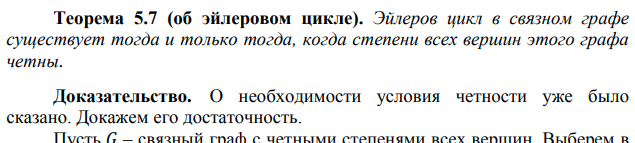

In [9]:
""" Оригинал: Теорема 5.7 (об эйлеровом цикле). Эйлеров цикл в связном графе
существует тогда и только тогда, когда степени всех вершин этого графа
четны. """
q = "О чем говорит теорема об эйлеровом цикле?"
pure = giga([HumanMessage(content=q)]).content
print(f"Pure: {pure}")

rag = rag_chain.invoke({"input": q})["answer"]
print(f"RAG: {rag}")

/Users/19563044/Documents/Giga/gigachain/.venv/lib/python3.11/site-packages/langchain_core/_api/deprecation.py:139: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(


Pure: Теорема об эйлеровом цикле гласит, что в любом графе без мостов и висячих ребер сумма степеней всех вершин равна удвоенному числу рёбер.
RAG: Теорема об эйлеровом цикле гласит, что в связном графе эйлеров цикл существует тогда и только тогда, когда степени всех вершин графа четны.


In [12]:
""" Оригинал:  Оказывается, присутствие в графе нечетных циклов (т.е. циклов
нечетной длины) – единственная причина, по которой граф не является
двудольным. """
q = "Короткий ответ: По каким причинам граф не будет двудольным? "
pure = giga([HumanMessage(content=q)]).content
print(f"Pure: {pure}\n")

rag = rag_chain.invoke({"input": q})["answer"]
print(f"RAG: {rag}")

Pure: Граф не будет двудольным, если он содержит цикл нечётной длины или хотя бы одну пару несмежных рёбер.

RAG: Граф не будет двудольным, если в нем содержатся нечетные циклы.


In [13]:
""" Оригинал: Термин набор означает конечную последовательность элементов.
Понятие набора отличается от понятия множества тем, что
* в наборе могут быть одинаковые элементы,
* порядок расположения элементов в наборе важен (наборы, состоящие
из одинаковых элементов, расположенных в разном порядке,
считаются различными). """
q = "Разница между словом и набором. Приведи пример."
pure = giga([HumanMessage(content=q)]).content
print(f"Pure: {pure}\n")

rag = rag_chain.invoke({"input": q})["answer"]
print(f"RAG: {rag}")

Pure: Слово — это лексическая единица языка, которая имеет определённое значение. Набор — это совокупность предметов, явлений, понятий, объединённых по какому-либо признаку.

Пример:

Слово «стол» — это лексическая единица русского языка, обозначающая предмет мебели для работы или приёма пищи.

Набор столовых приборов — это совокупность различных предметов (ложек, вилок, ножей), которые используются во время еды.

RAG: Разница между словом и набором заключается в том, что слово - это упорядоченная последовательность букв, в которой каждая буква может повторяться, тогда как набор - это просто последовательность элементов без учета их повторений или порядка.

Пример: "мама" - это слово, потому что оно состоит из букв, которые могут повторяться ("м" и "а"), и порядок букв имеет значение. "ма", "ам", "ама" - это другие слова, но "мама" - единственное слово из этих трех.

С другой стороны, набор "мама" будет содержать только одну запись, потому что набор не учитывает повторения элементов ил